In [101]:
import pickle
from sklearn.ensemble import VotingClassifier
import numpy as np
from scipy.sparse import load_npz
from sklearn.metrics import accuracy_score

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import KFold

In [86]:
X_train = load_npz('../vectors/tfidf_lemma/X_train_tfidf.npz')
y_train = np.load('../vectors/tfidf_lemma/y_train.npy')

X_test = load_npz('../vectors/tfidf_lemma/X_test_tfidf.npz')
y_test = np.load('../vectors/tfidf_lemma/y_test.npy')

labels = ['0','1','2','3']

In [87]:
with open('../models_dump/SVM_CV50_T50.pkl', 'rb') as file:
    SVM = pickle.load(file)

with open('../models_dump/RF_CV51_T51.pkl', 'rb') as file:
    RF = pickle.load(file)

In [88]:
SVM_y_pred = SVM.predict(X_test)

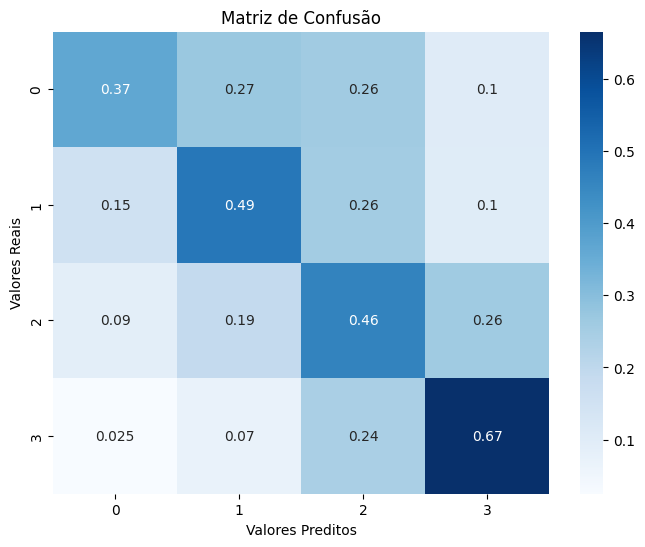

In [89]:
cm_SVM = confusion_matrix(y_test, SVM_y_pred)

cm_SVM = cm_SVM.astype('float') / cm_SVM.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(8, 6))
sns.heatmap(cm_SVM, annot=True, cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.title('Matriz de Confusão')
plt.xlabel('Valores Preditos')
plt.ylabel('Valores Reais')
plt.show()

In [90]:
weights = {'RF': [1,1,1,3], 'SVM': [3,2,2,1]}

In [91]:
def get_weighted_probabilities(models, X, weights):
    probabilities = [model.predict_proba(X) * weight for (model, weight) in zip(models, weights.values())]
    return np.sum(probabilities, axis=0)

In [92]:
ensemble_proba = get_weighted_probabilities([SVM, RF], X_test, weights)

In [93]:
ensemble_model = VotingClassifier(estimators=[
    ('RF', RF),
    ('SVM', SVM)
], voting='soft', weights=weights)

In [94]:
ensemble_model.fit(X_train, y_train)

VotingClassifier(estimators=[('RF',
                              RandomForestClassifier(class_weight={0: 0.0010416666666666667,
                                                                   1: 0.000625,
                                                                   2: 0.0004166666666666667,
                                                                   3: 0.000625},
                                                     max_depth=176,
                                                     n_estimators=167)),
                             ('SVM',
                              SVC(class_weight='balanced', probability=True))],
                 voting='soft',
                 weights={'RF': [1, 1, 1, 3], 'SVM': [3, 2, 2, 1]})

In [95]:
ensemble_predictions = np.argmax(ensemble_proba, axis=1)

In [96]:
print(f'Acurácia do Ensemble: {accuracy_score(y_test, ensemble_predictions)}')

Acurácia do Ensemble: 0.5054878048780488


In [107]:
def cv_scores(X, y):
    kf = KFold(n_splits=10, shuffle=True, random_state=42)

    # Inicializando listas para armazenar pontuações
    cross_val_scores = []

    # Realizando a validação cruzada manualmente
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Treinando os modelos com pesos
        SVM.fit(X_train, y_train)
        RF.fit(X_train, y_train)

        # Calculando probabilidades ponderadas usando a função personalizada
        weighted_probabilities = get_weighted_probabilities([SVM, RF], X_test, weights)

        # Convertendo probabilidades para previsões
        ensemble_predictions = np.argmax(weighted_probabilities, axis=1)

        # Calculando a acurácia e armazenando
        accuracy = np.sum(ensemble_predictions == y_test) / len(y_test)
        cross_val_scores.append(accuracy)
    return cross_val_scores

In [108]:
cross_val_scores = cv_scores(X_train, y_train)

# Exibindo as pontuações para cada fold
print("Pontuações da validação cruzada:", cross_val_scores)

# Exibindo a média das pontuações
print("Média das pontuações da validação cruzada:", np.mean(cross_val_scores))

Pontuações da validação cruzada: [0.5320121951219512, 0.5335365853658537, 0.5228658536585366, 0.5487804878048781, 0.5335365853658537, 0.48628048780487804, 0.5289634146341463, 0.5, 0.5411585365853658, 0.5137195121951219]
Média das pontuações da validação cruzada: 0.5240853658536585


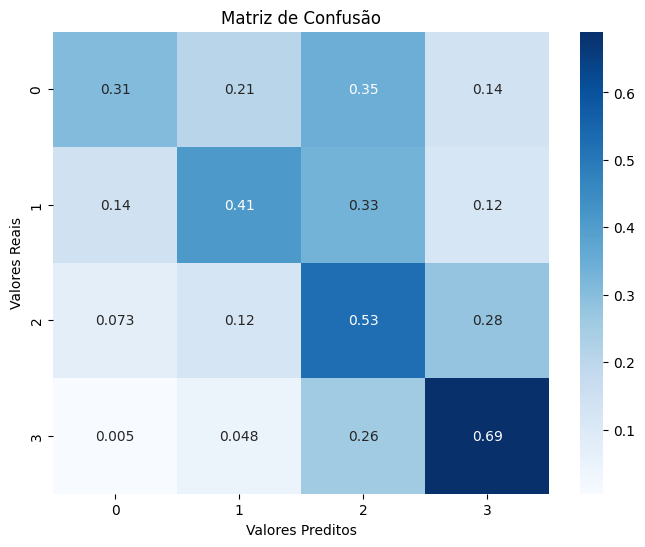

In [97]:
cm = confusion_matrix(y_test, ensemble_predictions)

cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.title('Matriz de Confusão')
plt.xlabel('Valores Preditos')
plt.ylabel('Valores Reais')
plt.show()

In [110]:
with open('../models_dump/SVM+RF_CV52_T50.pkl', 'wb') as file:
    pickle.dump(ensemble_model, file)